# POSE-ID-on

In this notebook two analyses will be performed:

- Comparison of a query with the whole dataset of poses
- Clustering of poses

## Libraries

In [ ]:
import numpy as np
import json
import os
import math
import matplotlib.pyplot as plt
import time
import copy
from copy import deepcopy
import pickle
from tqdm import tqdm
from math import isnan
import pandas as pd

from utils.data_viz import *
from clustering.Clustering import *
from clustering.clustering_and_reconstruction import *
from methods.Second_method import *
from methods.First_method import *
from utils.data_viz import *
from utils.utils import *

## Path definition

In this section we define the path from which the images and the joints are loaded. 

Moreover, we define the path in which the results of the comparisons are saved.

In [ ]:
dir_joints = 'Joints_semidef' #insert the path from which the joints are loaded
dir_im = 'Immagini_semidef' #insert the path from which the images are loaded

save_path = os.path.join(os.getcwd(), 'best_worst_cases') #insert the name of the path where to save the results
if not os.path.exists(save_path):                         # if it doesn't exist, it is created
    os.makedirs(save_path)

## Loading poses

The poses are loaded from the path defined. The convention of the file names are the OpenPose one. 
See the *load_poses* functions for more information.

In [ ]:
start = time.time()

dict_joints, dict_joints_SR_destrorso = load_poses(dir_im, dir_joints)

end = time.time()
print()
print(len(dict_joints), " poses were found and correctly loaded in ", round(end-start, 1), 'second')

## Visualization of pose and statue

With this simple function, the statue is shown with the corresponding joints.

artemide colonna 678_rendered.png


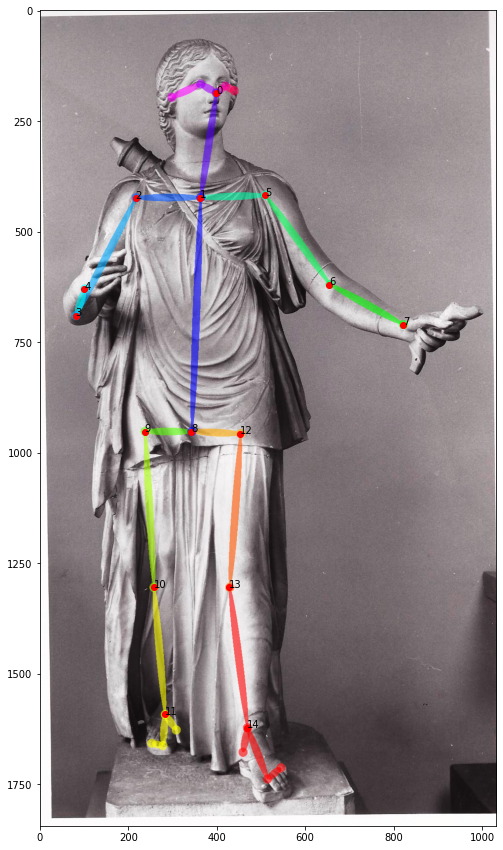

In [4]:
i = 509 #insert a number of a sample

show_pose(i, dict_joints, dir_im)

# 1. Compare poses

Both methods are applied.

1. the first class applies a method based on the angles between the **same limbs in different poses**;
2. the second class is based on a method that computes all the angles among the **different limbs of the same pose**, then compares the features obtained to the ones computed for another pose.


## Generation of comparison results

### First method

Mirroring and turning could be switched, making the computation slower.

In general, this method results slower than the second one.

In [ ]:
start = time.time()

best_worst_cases_1 = first_method_app(dict_joints_SR_destrorso, mirroring = False, turning = False)
 
end = time.time()
print(end-start)

### Second method

Faster then the first one. It's the same we use in the clustering step.

In [ ]:
start = time.time()

best_worst_cases_2 = second_method_app(dict_joints_SR_destrorso)
 
end = time.time()
print(end-start)

## Writing results on .txt

In order to speed up the pipeline, we suggest to save the results, once computed. We write these on .txt files that are saved in the path previously created and/or named.

In [ ]:
with open(os.path.join(save_path, 'best_worst_cases_1.txt'), 'wb') as fp: #First method. The name of the .txt can be changed
   pickle.dump(best_worst_cases_1, fp)

with open(os.path.join(save_path, 'best_worst_cases_2.txt'), 'wb') as fp: #Second method. The name of the .txt can be changed
    pickle.dump(best_worst_cases_2, fp)

## Uploading results from .txt

As said, the results can be uploaded directly from .txt file.

### First method

In [ ]:
best_worst_cases_1 = {}
with open (os.path.join(save_path, 'best_worst_cases_1.txt'), 'rb') as fp: #Insert the name of the .txt with the results
    best_worst_cases_1 = pickle.load(fp)

### Second method

In [ ]:
best_worst_cases_2 = {}
with open (os.path.join(save_path, 'best_worst_cases_2.txt'), 'rb') as fp: #Insert the name of the .txt with the results
    best_worst_cases_2 = pickle.load(fp)

## Showing results from comparison

The function plots the query pose, the four closest poses and the farthest one.

In [ ]:
plot_images(dir_im, 10, best_worst_cases_1) #insert a number of a sample and the dictionary
                                           #of the results of the selected method

## Saving images of results

All the comparison of each statue can be saved as images, as the one shown before.

The method and the dictionary of saved results must be indicated.

In [ ]:
for j in tqdm(range(len(best_worst_cases_2))):
    try:
        save_images(dir_im, j, method = 2, dictionary = best_worst_cases_2)
    except:
        pass

# 2. Clustering

The clustering is based on the second method. The features on which the clustering is applied are the 91 angles formed by the limbs of a pose.

In our paper, we applied a K-Medians algorithm, with a non-Euclidean distance, in order to deal with angular quantities.
K-Means and Hierarchical Clustering are also available.

The available distances are: euclidean and angular. The former is not suggested because it couldn't converge, due to the nature of the problem.

## Clustering

A number of cluster can be selected. The output provides a dataframe with each statue labeled, and information about centroids.

In [ ]:
n_clusters = 10 #insert the number of desired clusters
distance = 'angular' #'angular' and 'euclidean' available
method = 'Hierarchical' #'K-means', 'K-medians' and 'Hierarchical' available

In [ ]:
df_clustering, relevant_features_centroids, centroids = clustering(create_features(dict_joints_SR_destrorso)[0], 
                                                                   create_features(dict_joints_SR_destrorso)[1], 
                                                                   n_clusters, 
                                                                   distance, 
                                                                   method)

## More clustering and pose reconstruction

Several clustering configurations can be run.

Moreover, the results of these algorithms can be both stored and shown.

We save:
- all the reconstructed poses of the centroids, as .png files;
- a .txt file with all the clusters.

In [ ]:
n_cluster_list = [2,3] #insert the desired numbers of clusters for each clustering

In [ ]:
df_cls, rec_poses = clustering_several_n(n_cluster_list, dict_joints_SR_destrorso)

In [ ]:
watch_samples(2, df_cls,rec_poses,n_cluster_list, dir_im) #insert the number of clusters of the clustering to be shown